## Library Import

In [87]:
import pandas as pd
import numpy as np
import os
import glob
import re

from time import time 
from collections import defaultdict

from LeIA import SentimentIntensityAnalyzer

## Data Import

In [88]:
chat_messages_path = './chat-sem-nps'
chat_files = glob.glob(os.path.join(chat_messages_path,'*.txt'))

In [89]:
chat_files

['./chat-sem-nps\\63efd0473dd0fdcd6e0b14e7.txt',
 './chat-sem-nps\\63efd99a3dd0fdcd6e0b19ea.txt',
 './chat-sem-nps\\63efdfbc3dd0fdcd6e0b1cbc.txt',
 './chat-sem-nps\\63f0c12b7bc2d7d6a30e873c.txt',
 './chat-sem-nps\\63f27f603dd0fdcd6e0b2f75.txt',
 './chat-sem-nps\\63f3824e7bc2d7d6a30e87a2.txt',
 './chat-sem-nps\\63f3b1847bc2d7d6a30e87d8.txt',
 './chat-sem-nps\\63f3b18c7bc2d7d6a30e87ea.txt',
 './chat-sem-nps\\63f3b18d7bc2d7d6a30e87f7.txt',
 './chat-sem-nps\\63f3cd933dd0fdcd6e0b50bd.txt',
 './chat-sem-nps\\63f3cfb83dd0fdcd6e0b5155.txt',
 './chat-sem-nps\\63f4b61c3dd0fdcd6e0b5955.txt',
 './chat-sem-nps\\63f604a53dd0fdcd6e0b710a.txt',
 './chat-sem-nps\\63f615017bc2d7d6a30e8836.txt',
 './chat-sem-nps\\63f616e77bc2d7d6a30e884e.txt',
 './chat-sem-nps\\63f616f87bc2d7d6a30e885a.txt',
 './chat-sem-nps\\63f6196e3dd0fdcd6e0b7e2d.txt',
 './chat-sem-nps\\63f61d1b7bc2d7d6a30e886d.txt',
 './chat-sem-nps\\63f61ddc7bc2d7d6a30e8889.txt',
 './chat-sem-nps\\63f65efa7bc2d7d6a30e88da.txt',
 './chat-sem-nps\\63

Creation of data dictionaries

In [90]:
def import_data(chat_files_list):
    # Create dictionaries to structure dataframe data
    chats_dict = {'id':[],'num_client_messages':[],'num_service_messages':[]}
    messages_dict = {'id':[],'chat_id':[],'order_in_chat':[],'text':[],'source':[]}

    line_type = 'n'
    sender_type = 'a'

    # Start global chat and message counter
    message_id = 0
    chat_id = 1
    message_order = 0
    num_client_messages = 0
    num_service_messages = 0

    for chat in chat_files_list:
        with open(chat, 'r',encoding='utf-8') as file:
            # Iterate through each line in chat file
            for line in file:

                # Skip empty line
                if line.strip() == '':
                    continue

                 # End of chat (counters: update chat and restart messages)
                if line.strip() == '_(Não é preciso responder essa mensagem.)_':
                    chats_dict['id'].append(chat_id)
                    chats_dict['num_client_messages'].append(num_client_messages)
                    chats_dict['num_service_messages'].append(num_service_messages)
                    chat_id += 1
                    num_client_messages = 0
                    num_service_messages = 0
                    message_order = 0
                    continue

                # Verification of line type
                try:
                    second_item = line.split(' ')[1]                    
                    devided_second = second_item.split('--')[1]

                    if devided_second == 'Atendente:':
                        sender_type = 'a'
                        line_type = 'new'
                    elif devided_second == 'Cliente:':
                        sender_type = 'c'
                        line_type = 'new'
                    else:
                        line_type = 'continuation'                       
                except:
                    line_type = 'continuation'

                if sender_type == 'a':
                    if line_type == 'new':
                        # Updates and appends messages id to message dict
                        message_id += 1
                        messages_dict['id'].append(message_id)

                        # Appends chat id to message dict
                        messages_dict['chat_id'].append(chat_id)

                        # Updates and adds message order to message dict
                        messages_dict['order_in_chat'].append('NA')

                        # Updates number of service messages
                        num_service_messages += 1

                        # Adds text line to message dict
                        message_text = line.split('Atendente:')[1].strip()
                        messages_dict['text'].append(message_text)

                        # Adds message source
                        messages_dict['source'].append('A')

                    else :
                        # Adds text to previous line
                        messages_dict['text'][message_id-1] = messages_dict['text'][message_id-1].strip() + ' ' + line.strip()

                elif sender_type == 'c':
                    if line_type == 'new':
                        # Updates and appends messages id to message dict
                        message_id += 1
                        messages_dict['id'].append(message_id)

                        # Appends chat id to message dict
                        messages_dict['chat_id'].append(chat_id)

                        # Updates and adds message order to message dict
                        message_order += 1
                        messages_dict['order_in_chat'].append(message_order)

                        # Updates number of client messages
                        num_client_messages += 1

                        # Adds text line to message dict
                        message_text = line.split('Cliente:')[1].strip()
                        messages_dict['text'].append(message_text)

                        # Adds message source
                        messages_dict['source'].append('C')

                    else:
                        # Adds text to previous line
                        messages_dict['text'][message_id-1] = messages_dict['text'][message_id-1].strip() + ' ' + line.strip()
    
    chats_df = pd.DataFrame(data=chats_dict)
    messages_df = pd.DataFrame(data=messages_dict)
    return {'chats':chats_df,'messages':messages_df}


In [91]:
output = import_data(chat_files)
chats_df, messages_df = output['chats'], output['messages']

Create dataframes:

Number of chats verification:

In [92]:
chats_df.id.unique().size == messages_df.chat_id.unique().size

True

Remove attendant messages:

In [93]:
cl_messages_df = messages_df[messages_df['source'] == 'C']

print('Percentage of client messages:')
print(round(cl_messages_df.shape[0]/messages_df.shape[0],4)*100,'%')

Percentage of client messages:
48.9 %


In [94]:
cl_messages_df.reset_index(drop=True,inplace=True)

In [95]:
cl_messages_df

,id,chat_id,order_in_chat,text,source
0,6,2,1,"Só isso, obrigado",C
1,11,2,2,bom dia,C
2,16,3,1,Aguardando,C
3,18,3,2,Ok,C
4,21,3,3,Preciso saber se consigo mudar de número e se ...,C
...,...,...,...,...,...
180391,368870,7246,1,Registrei um problema no chatguru que tem sido...,C
180392,368871,7246,2,"Prazer, Maria Heloísa! Tudo bem sim e você?",C
180393,368873,7246,3,Boa tarde!,C
180394,368881,7246,4,Blz,C


In [96]:
cl_messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180396 entries, 0 to 180395
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             180396 non-null  int64 
 1   chat_id        180396 non-null  int64 
 2   order_in_chat  180396 non-null  object
 3   text           180396 non-null  object
 4   source         180396 non-null  object
dtypes: int64(2), object(3)
memory usage: 6.9+ MB


In [97]:
chats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7246 entries, 0 to 7245
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   id                    7246 non-null   int64
 1   num_client_messages   7246 non-null   int64
 2   num_service_messages  7246 non-null   int64
dtypes: int64(3)
memory usage: 170.0 KB


## LeIA Application

In [98]:
def extract_leia_sentiment(compound):
    sent_output = {'label':'', 'new_score':0}    
    
    sent_output['new_score'] = (compound + 1) / 2
    
    if compound == 0:
        sent_output['label'] = 0
    elif compound > 0.2:
        sent_output['label'] = 2        
    elif compound > 0:
        sent_output['label'] = 1
    elif compound >= -0.2 :
        sent_output['label'] = -1
    else:
        sent_output['label'] = -2
        
    return sent_output

In [99]:
%%time

analyzer = SentimentIntensityAnalyzer()
leia_classification_df = cl_messages_df.assign(
    score=cl_messages_df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
)

CPU times: total: 10.4 s
Wall time: 13.5 s


In [100]:
leia_classification_df

,id,chat_id,order_in_chat,text,source,score
0,6,2,1,"Só isso, obrigado",C,0.4404
1,11,2,2,bom dia,C,0.4215
2,16,3,1,Aguardando,C,0.0000
3,18,3,2,Ok,C,0.2263
4,21,3,3,Preciso saber se consigo mudar de número e se ...,C,0.0772
...,...,...,...,...,...,...
180391,368870,7246,1,Registrei um problema no chatguru que tem sido...,C,-0.4019
180392,368871,7246,2,"Prazer, Maria Heloísa! Tudo bem sim e você?",C,0.8588
180393,368873,7246,3,Boa tarde!,C,0.4926
180394,368881,7246,4,Blz,C,0.0000


In [101]:
leia_classification_df = leia_classification_df.assign(
    classification_score = leia_classification_df['score'].apply(lambda x: extract_leia_sentiment(x)['new_score']),
    classification_label = leia_classification_df['score'].apply(lambda x: extract_leia_sentiment(x)['label']),
)
leia_classification_df.drop(columns=['score','source'],inplace=True)
leia_classification_df

,id,chat_id,order_in_chat,text,classification_score,classification_label
0,6,2,1,"Só isso, obrigado",0.72020,2
1,11,2,2,bom dia,0.71075,2
2,16,3,1,Aguardando,0.50000,0
3,18,3,2,Ok,0.61315,2
4,21,3,3,Preciso saber se consigo mudar de número e se ...,0.53860,1
...,...,...,...,...,...,...
180391,368870,7246,1,Registrei um problema no chatguru que tem sido...,0.29905,-2
180392,368871,7246,2,"Prazer, Maria Heloísa! Tudo bem sim e você?",0.92940,2
180393,368873,7246,3,Boa tarde!,0.74630,2
180394,368881,7246,4,Blz,0.50000,0


<Axes: >

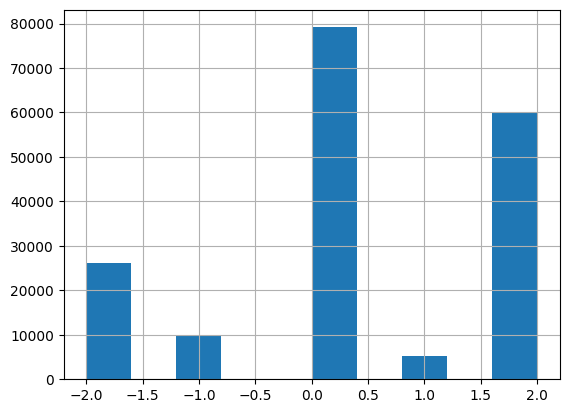

In [102]:
leia_classification_df['classification_label'].hist()

## Definition of whole chat Sentiment:

### Strategy for chat sentiment definition:

Since the model analyzes sentences by breaking them down into words and assigning weights to them, there is an optimal sentence length for analysis, it should neither be too short nor too extense. Adittionally NLP models often have a token limit/request, making it often necessary to limit sentence lengths based on tokens.

Based on that and the fact that our document of interest is a conversation between two people, it is necessary to define a method to convert the sentiment of each message into a general one.

The chosen approach for that goal is:
1. Classify each chat entry individually: each message sentiment will be ranked between -2 (negative) and +2 (positive)
2. Define weights based on the order of appearance of each message: Later messages shall have greater weights than messages on the beginning of the chat
3. The message weights are calculated as the ratio between the chat message order squared and the sum of the squared order values of all chat messages, that is: 

$$w_i = \frac{o_i^2}{\displaystyle\sum_{0}^{n} o_k^2}$$

Where: 
- "$o_i$" is the chat message of order "$i$"
- "$n$" is the number of messages in the chat
- "$k$" is the iteration variable of the sum

4. Calculate the weighted average of the whole chat based on message weight ($w_i$) and classification value ($v_i$):

$$\overline{x} = \frac{\sum w_i*v_i }{\sum w_i}$$



### Application of strategy on test chat:

Import and preprocess chat file:

In [103]:
file = './test_chat.txt'
files = [file]

In [104]:
dataframes = import_data(files)

In [105]:
test_chat_df, test_messages_df = dataframes['chats'], dataframes['messages']

Cleanup data from attendant messages:

In [106]:
def messages_cleanup(messages_df):
    cleaned_message_df = messages_df[messages_df['source'] == 'C']
    cleaned_message_df.reset_index(drop=True,inplace=True)
    
    return cleaned_message_df

In [107]:
cl_test_messages_df = messages_cleanup(test_messages_df)
cl_test_messages_df

,id,chat_id,order_in_chat,text,source
0,1,1,1,Muito obrigado,C
1,2,1,2,Pode encerrar,C
2,5,1,3,Muito obrigado pelo suporte de vocês,C
3,6,1,4,Perfeito,C
4,9,1,5,ok,C
5,10,1,6,40192023181000000000900001101815693300000039200,C
6,12,1,7,Agradeço,C
7,13,1,8,Ainda não,C
8,19,1,9,O custo de vocês está muito alto,C
9,20,1,10,"Alem de mais números, outros canais tbm, insta...",C


Apply LeIA classifier to chat messages:

In [108]:
def chat_classification(messages_df):
    
    analyzer = SentimentIntensityAnalyzer()
    
    # Apply leia classifier
    classified_df = messages_df.assign(
    score=messages_df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound']))
    
    # Generate labels and normalized classification score
    classified_df = classified_df.assign(
        classification_score = classified_df['score'].apply(lambda x: extract_leia_sentiment(x)['new_score']),
        classification_label = classified_df['score'].apply(lambda x: extract_leia_sentiment(x)['label']),
    )
    
    # Remove unecessary columns
    classified_df.drop(columns=['score','source'],inplace=True)
    
    return classified_df

In [109]:
classified_messages_df = chat_classification(cl_test_messages_df)

In [110]:
classified_messages_df.head(20)

,id,chat_id,order_in_chat,text,classification_score,classification_label
0,1,1,1,Muito obrigado,0.72020,2
1,2,1,2,Pode encerrar,0.50000,0
2,5,1,3,Muito obrigado pelo suporte de vocês,0.72020,2
3,6,1,4,Perfeito,0.65910,2
4,9,1,5,ok,0.61315,2
5,10,1,6,40192023181000000000900001101815693300000039200,0.50000,0
6,12,1,7,Agradeço,0.50000,0
7,13,1,8,Ainda não,0.35200,-2
8,19,1,9,O custo de vocês está muito alto,0.50000,0
9,20,1,10,"Alem de mais números, outros canais tbm, insta...",0.50000,0


Calculate weights:

In [111]:
df = classified_messages_df.copy()

In [113]:
def calculate_weight(order:int, n_messages:int):
    if n_messages < 1 :
        raise Exception('There should be at least one message to be analyzed')
    den = 0
    for i in range(1, n_messages + 1):
        den += i**2
    w = (order**2) / den
    
    return w

In [114]:
def generate_weighted_df(df):
    n_messages = df.shape[0]
    df = df.assign(
        message_weight = df.apply(lambda x: calculate_weight(x['order_in_chat'],n_messages), axis=1)
    )
    
    return df

In [115]:
df = generate_weighted_df(df)

,id,chat_id,order_in_chat,text,classification_score,classification_label,message_weight
0,1,1,1,Muito obrigado,0.72020,2,0.000668
1,2,1,2,Pode encerrar,0.50000,0,0.002674
2,5,1,3,Muito obrigado pelo suporte de vocês,0.72020,2,0.006016
3,6,1,4,Perfeito,0.65910,2,0.010695
4,9,1,5,ok,0.61315,2,0.016711
5,10,1,6,40192023181000000000900001101815693300000039200,0.50000,0,0.024064
6,12,1,7,Agradeço,0.50000,0,0.032754
7,13,1,8,Ainda não,0.35200,-2,0.042781
8,19,1,9,O custo de vocês está muito alto,0.50000,0,0.054144
9,20,1,10,"Alem de mais números, outros canais tbm, insta...",0.50000,0,0.066845


In [116]:
def calculate_chat_sentiment_coef(df):
    num = 0
    den = 0
    for idx, row in df.iterrows():
        num += row['classification_label'] * row['message_weight']
        den += row['message_weight']
    coef = num / den
    return coef

In [182]:
coefficient = calculate_chat_sentiment_coef(df)
print(coefficient)

0.6016042780748664


In [186]:
def generate_sentiment_label(coef:float):
    label = ''
    if coef > 2 or coef <-2:
        return 'Houve um erro, por favor entre em contato com o suporte da ChatGuru'
    
    if coef <= -1:
        label = 'Insatisfeito'        
    elif coef < -0.2:
        label = 'Levemente Insatisfeito'
    elif coef <= 0.2:
        label = 'Neutro'
    elif coef < 1:
        label = 'Levemente Satisfeito'
    else:
        label = 'Satisfeito'
    
    return label

In [187]:
print(generate_sentiment_label(3))

Houve um erro, por favor entre em contato com o suporte da ChatGuru


## Report Creation

In [183]:
import reportlab
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Table, TableStyle, Spacer
from reportlab.lib.styles import getSampleStyleSheet

In [184]:
def format_chat(chat_path):
    
    chat_text = []
    line_type = ''
    sender_type = ''
    
    with open(chat_path, 'r',encoding='utf-8') as file:
        for line in file:
            
            # Skip empty line
            if line.strip() == '':
                continue

             # End of chat
            if line.strip() == '_(Não é preciso responder essa mensagem.)_':
                break

            # Verification of line type
            try:
                second_item = line.split(' ')[1]             
                devided_second = second_item.split('--')[1]

                if devided_second.lower() == 'atendente:':
                    sender_type = 'a'
                    line_type = 'new'
                elif devided_second.lower() == 'cliente:':
                    sender_type = 'c'
                    line_type = 'new'
                else:
                    line_type = 'continuation'                       
            except:
                line_type = 'continuation'

            if sender_type == 'a':
                if line_type == 'new':
                    # Adds text line whole chat string
                    message_text = line.split('Atendente:')[1].strip()
                    chat_text.append('[Atendente] '+ message_text)

                else :
                    # Adds text to previous line
                    index = len(chat_text) - 1
                    chat_text[index] = chat_text[index] + line.strip()

            elif sender_type == 'c':
                if line_type == 'new':
                    # Adds text line whole chat string
                    message_text = line.split('Cliente:')[1].strip()
                    chat_text.append('[Cliente] '+ message_text)

                else :
                    # Adds text to previous line
                    index = len(chat_text) - 1
                    chat_text[index] = chat_text[index] + line.strip()

    return chat_text

In [255]:
def create_report(report_name:str, formated_chat:str, sentiment_coef:float):
    # Create document
    doc = SimpleDocTemplate(report_name, pagesize=letter)
    
    # Report element list
    elements = []
    # Styles Class Instance
    styles = getSampleStyleSheet()
    # Creates a style for centered text
    centered_style = PS(name='CenteredStyle', parent=styles['Heading3'], alignment=1)
    
    # TITLE  
    title = Paragraph('Relatório de Análise de Sentimento do Chat', styles['Title'])
    elements.append(title)
    elements.append(Spacer(1,20))
    
    # SECTION - "Method for Sentiment Analysis"
    section_title = Paragraph('Método para Análise de Sentimento',styles['Heading1'])
    elements.append(section_title)
    
    # SUBSECTION - "Method Description"
    subtitle = Paragraph('Descrição do Método',styles['Heading2'])
    elements.append(subtitle)
    elements.append(Spacer(1,10))
    
    # TEXT - "method description"
    method_introduction = 'O método para a obtenção da estimativa do sentimento de um cliente durante '\
    'uma interação com o atendimento consiste em :'
    
    text = Paragraph(method_introduction,styles['Normal'])
    elements.append(text)
    elements.append(Spacer(1,10))    
    
    method_list = [
        'Análise do sentimento de todas as mensagens dos clientes',
        'Cálculo do peso de cada mensagem',
        'Cálculo da média do sentimento do chat completo',
        'Interpretação do resultado da análise'
    ]
    
    numbered_list = ListFlowable(
        [Paragraph(f"{item}", styles['Normal']) for i, item in enumerate(method_list, start=1)],
        bulletType='bullet',
        leftIndent=20,
    ) 
    elements.append(numbered_list)
    elements.append(Spacer(1,10))
    
    entry_1 = 'O primeiro passo consiste na aplicação do modelo de aprendizado de máquina treinado para a '\
    'classificação do sentimento do cliente em cada uma das mensagens enviadas para o atendente, gerando assim '\
    'um nível estimado de satisfação do cliente que varia entre "Satisfeito", "Levemente Satisfeito", "Neutro"'\
    ', "Levemente Insatisfeito" ou "Insatisfeito".'
    
    text = Paragraph(entry_1,styles['Normal'])
    elements.append(text)
    elements.append(Spacer(1,10))
    
    entry_2 = 'O que se segue é a transformação das classificações dos sentimentos individuais '\
    'expressos em cada uma das mensagens em pesos matemáticos que compõem o sentimento do cliente '\
    'durante todo o atendimento. Esses pesos são definidos seguindo-se a metodologia formulada internamente'\
    ' pelo time de Inteligência Artificial da ChatGuru.'
    
    text = Paragraph(entry_2,styles['Normal'])
    elements.append(text)
    elements.append(Spacer(1,10))
    
    entry_3 = 'Usando-se parâmetros obtidos do chat completo e do modelo de IA da ChatGuru, é calculado um '\
    'coeficiente numérico de satisfação do atendimento completo.'
    
    text = Paragraph(entry_3,styles['Normal'])
    elements.append(text)
    elements.append(Spacer(1,10))
    
    entry_4 = 'Por fim, esse coeficiente de satisfação é interpretado em termos não-matemáticos para ser '\
    'apreciado pelo contratante do serviço.'
    
    text = Paragraph(entry_4,styles['Normal'])
    elements.append(text)
    elements.append(Spacer(1,20))
    
    # SECTION - "Sentiment Analysis"
    section_title = Paragraph('Análise de Sentimento',styles['Heading1'])
    elements.append(section_title)
    
    # SUBSECTION - "Chat Presentation"
    subtitle = Paragraph('Apresentação do Chat',styles['Heading2'])
    elements.append(subtitle)
    elements.append(Spacer(1,10))
    
    # TEXT - "chat content"
    for line in formated_chat:
        chat = Paragraph(line, styles['Normal'])
        elements.append(chat)
        elements.append(Spacer(1,5))
    
    # SUBSECTION - "Analysis result"
    subtitle = Paragraph('Resultados da Análise',styles['Heading2'])
    elements.append(subtitle)
    elements.append(Spacer(1,10))
    
    # TEXT - "analysis result intro"
    analysis_result = 'Ao se aplicar o método já descrito neste relatório, o coeficiente de satisfação do usuário na '\
    'conversa apresentada como objeto de análise foi de:'
    text = Paragraph(analysis_result, styles['Normal'])
    elements.append(text)
    elements.append(Spacer(1,8))
    
    # TEXT - "sentiment coefficient"
    str_coef = str(round(sentiment_coef,3))
    text = f"coeficiente de satisfação = {str_coef}"
    centered_text = Paragraph(text, centered_style)
    elements.append(centered_text)
    elements.append(Spacer(1,10))
    
    # TEXT - "result interpretation"
    sentiment_label = generate_sentiment_label(sentiment_coef)
    interpretation = f"Dado o coeficiente de satisfação apresentado, podemos estimar que o cliente se sentiu:"
    text = Paragraph(interpretation, styles['Normal'])
    elements.append(text)
    
    centered_text = Paragraph(sentiment_label, centered_style)
    elements.append(centered_text)
    elements.append(Spacer(1,10))

    # Build the rest of the report
    doc.build(elements)

    return doc

In [254]:
formated_chat = format_chat('./test_chat.txt')
create_report('test_report.pdf',formated_chat,coefficient)